In [121]:
paper_data_file = "big_paper_data.csv"
citations_file = "big_citations.csv"

In [122]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier

In [123]:
paper_data = pd.read_csv(paper_data_file)
print(paper_data.columns)
citations = pd.read_csv(citations_file)
print(citations.columns)

Index(['paperId', 'title', 'embedding'], dtype='object')
Index(['source', 'target'], dtype='object')


In [124]:
def get_embedding_matrix(series):
    return np.vstack(series.apply(eval).apply(np.array).values)

all_embeddings = get_embedding_matrix(paper_data.embedding)
all_embeddings.shape

(1524, 768)

# Supervised Learning

In [125]:
def score_model(model):
    train_scores = []
    test_scores = []

    for source_paper in np.unique(citations.source):
        citation_group = citations[citations.source == source_paper].target.values
        relevant_mask = paper_data.paperId.apply(set(citation_group).__contains__).values
        relevant_embeddings = all_embeddings[relevant_mask]
        irrelevant_embeddings = all_embeddings[~relevant_mask]

        good_train, good_test = train_test_split(relevant_embeddings, test_size=0.4)
        bad_train, bad_test = train_test_split(irrelevant_embeddings, test_size=0.8)
        y_train = np.array([1] * len(good_train) + [0] * len(bad_train))
        X_train = np.vstack([good_train, bad_train])
        y_test = np.array([1] * len(good_test) + [0] * len(bad_test))
        X_test = np.vstack([good_test, bad_test])

        model.fit(X_train, y_train)
        train_score = model.score(X_train, y_train)
        test_score = model.score(X_test, y_test)
        train_scores.append(train_score)
        test_scores.append(test_score)

    train_scores = np.array(train_scores)
    test_scores = np.array(test_scores)

    return train_scores.mean(), test_scores.mean()

In [126]:
class RecenteringTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.center = None
    
    def fit(self, X, y):
        self.center = X[y].mean(axis=0)
        return self
    
    def transform(self, X):
        return np.abs(X - self.center)

In [134]:
models = [
    LogisticRegression(),
    make_pipeline(RecenteringTransformer(), LogisticRegression()),
    make_pipeline(LinearDiscriminantAnalysis(), LogisticRegression()),
    make_pipeline(PCA(n_components=10), LogisticRegression()),
    make_pipeline(PCA(n_components=50), LogisticRegression()),

    RandomForestClassifier(),
    make_pipeline(RecenteringTransformer(), RandomForestClassifier()),
    make_pipeline(LinearDiscriminantAnalysis(), RandomForestClassifier()),
    make_pipeline(PCA(n_components=10), RandomForestClassifier()),
    make_pipeline(PCA(n_components=50), RandomForestClassifier()),
]

In [135]:
train_scores = []
test_scores = []
for model in models:
    train_score, test_score = score_model(model)
    train_scores.append(train_score)
    test_scores.append(test_score)

/usr/local/Caskroom/miniconda/base/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/Caskroom/miniconda/base/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_

In [139]:
def make_name(model):
    if isinstance(model, Pipeline):
        return "+".join(make_name(step) for step in model.named_steps.values())
    else:
        return str(model)

model_names = [make_name(model) for model in models]
scores = pd.DataFrame()
scores["model"] = model_names
scores["train"] = train_scores
scores["test"] = test_scores
scores

,model,train,test
0,LogisticRegression(),1.000000,0.970110
1,RecenteringTransformer()+LogisticRegression(),1.000000,0.976664
2,LinearDiscriminantAnalysis()+LogisticRegression(),0.996885,0.949399
3,PCA(n_components=10)+LogisticRegression(),0.948999,0.973897
4,PCA(n_components=50)+LogisticRegression(),0.988120,0.955529
5,RandomForestClassifier(),1.000000,0.984958
6,RecenteringTransformer()+RandomForestClassifier(),1.000000,0.984199
7,LinearDiscriminantAnalysis()+RandomForestClass...,1.000000,0.915138
8,PCA(n_components=10)+RandomForestClassifier(),0.999891,0.982183
9,PCA(n_components=50)+RandomForestClassifier(),1.000000,0.984091


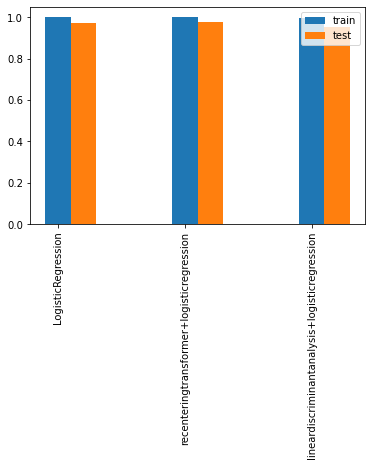

In [ ]:
x_pos = np.arange(len(train_scores))
plt.bar(x_pos, train_scores, width=0.2, label="train")
plt.bar(x_pos + 0.2, test_scores, width=0.2, label="test")
plt.xticks(x_pos, model_names, rotation=90)
plt.legend()